# The vaccine is coming

Well, it's officially 2021, and we have gained multipled potent vaccines that are effective against the evil virus that plagued 2020 known as SARS-Cov-2. In this notebook, I wanted to explore a family of models known as SIR (Susceptible-Infected-Recovered) models. In this notebook, I briefly explore three variations of SIR models: SIR model with constant population without any births or deaths; a SIR model with constant population with births and deaths; and a SIR model with constant population, births and deaths and a vaccine intervention on newborns.

The purpose of this notebook is to understand

    1) the herd immunity threshold in each model;
    2) the peak infections amount; and,
    3) the relationship between the model parameters and the aforementioned quantities. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
from scipy.integrate import odeint
from scipy.optimize import curve_fit as cf

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

## SIR model, constant population, no births, no deaths

In the simplest SIR model, Susceptible individuals are infected at a rate proportional to the rate at which they come in contact with infected individuals within the population, $\beta \frac{I}{N}$, and infected individuals remain sick for a period of time $\gamma$ before they recover.

$$
\frac{d}{dt} S = - \beta \frac{I}{N}S\\
\frac{d}{dt} I = \beta \frac{I}{N}S - \gamma I\\
\frac{d}{dt} R = \gamma I
$$


Infections will peak when $\frac{d}{dt}I = 0$, which happens when
$$
\frac{S^*}{N} = \frac{\gamma}{\beta} = \frac{1}{r_0}
$$

This is the point at which herd immunity takes place. Thus, herd immunity happens when $1 - \frac{1}{r_0}$ of the population has been infected and possibly recovered. As $t\rightarrow \infty$, $I \rightarrow 0$. In this model, the limiting behavior of the infected population is always to go to zero -- in other words, the disease always dies out in this model.

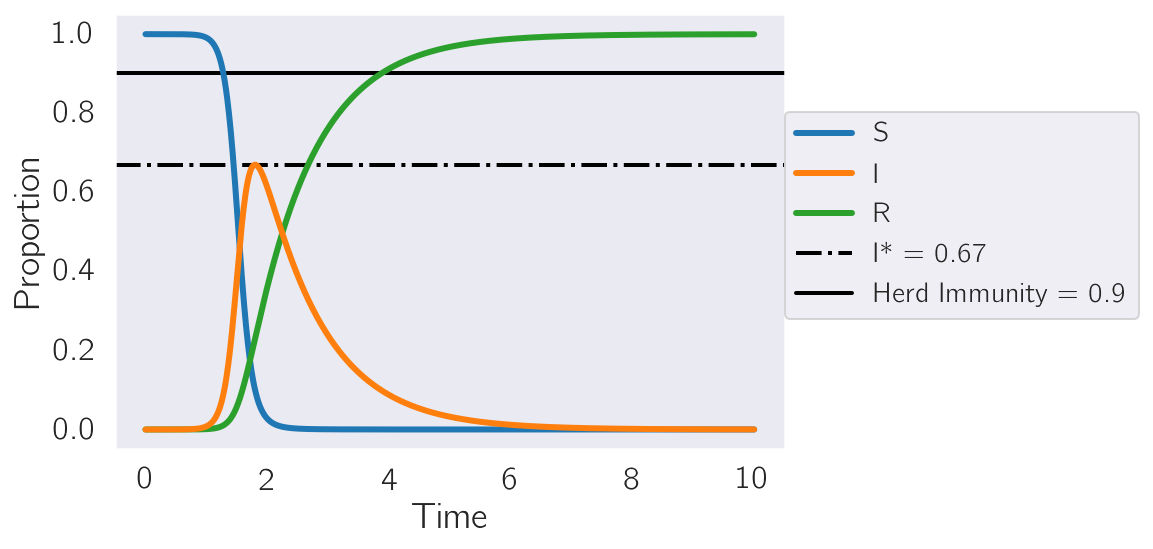

In [409]:
def SIR_basic(V, t, params):
    """ODE for basic SIR model"""
    S, I, R = V
    N = S + I + R
    b, g = params

    dsdt = -b * S * I / N
    didt = b * S * I / N - g * I
    drdt = g * I

    return [dsdt, didt, drdt]


def plot_sir(sir):
    """A wrapper function to always plot the SIR curves and label them."""
    # normalize sir:
    sir = sir / sir.sum(axis=1)[:, np.newaxis]
    plt.plot(t, sir[:, 0], label='S', lw=3)
    plt.plot(t, sir[:, 1], label='I', lw=3, zorder=np.inf)
    plt.plot(t, sir[:, 2], label='R', lw=3)

    # plot a line showing the peak infection propotion:
    plt.axhline(sir[:, 1].max(),
                label='I* = {0:.2g}'.format(sir[:, 1].max()),
                ls='-.', color='black', zorder=0)

    # line showing herd immunity (I + R):
    tmax = np.where(sir[:, 1] == sir[:, 1].max())[0]
    dstar = (sir[:, 1] + sir[:, 2])[tmax][0]
    plt.axhline(dstar, label='Herd Immunity = {0:.2g}'.format(dstar),
                color='black', zorder=0)
    # prettify:
    plt.xlabel('Time')
    plt.ylabel('Proportion')
    plt.legend(loc=(1,.3))

# simulation
t = np.linspace(0, 10, 1000)  # time to run simulation
V0 = np.array([10 ** 6, 1, 0])  # initial conditions
N = V0.sum()  # total pop size:
sir = odeint(SIR_basic, V0, t, args=([10, 1],))
plot_sir(sir)

Another way to visualize the relationship between Susceptible and Infected individuals is to generate a phase portrait that plots the number of infected individuals versus the number of susceptibles. I do this in the plot below. Notice how the curves are smooth and, more importantly, do not show any cyclical behavior. In the phase portrait below, darker grays are indicative of an $R_0$ closer to 1. Notice that as $R_0$ increases, the peak infected proportion increases markedly. All dynamic trajectories start around the point $(S_0, I_0) \sim (1, 10^{-6})$. The points at which the simulation ended (which should be close to $(S_\infty, I_\infty)$ are marked in red.

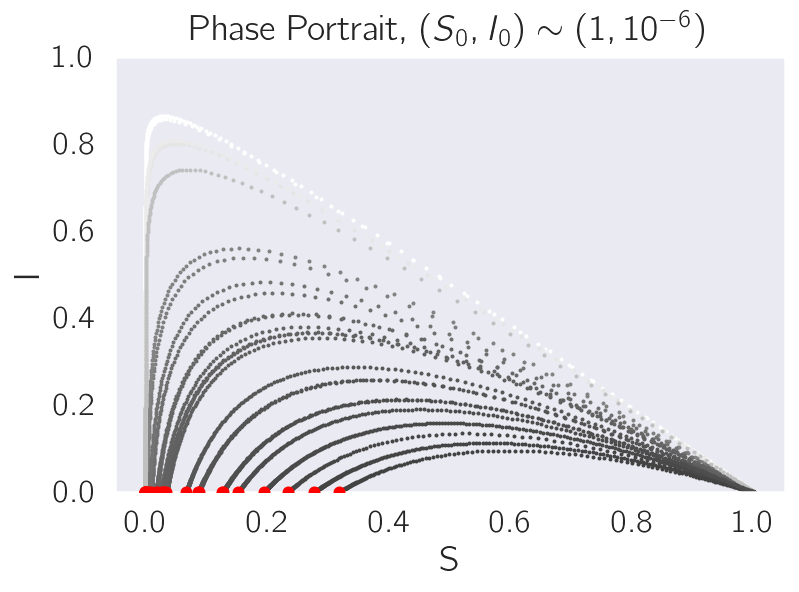

In [478]:
t = np.linspace(0, 50, 5000)

# run 25 simulations spanning a variety of r_0s:
def plot_simulations(func, args=None, t=np.linspace(0, 50, 5000)):
    """Simulate a variety of r_0 for various SIR models, for r_0 > 1.6."""
    i = 0
    while i < 25:
        beta = np.random.uniform(3, 20)
        gamma = np.random.uniform(0, 10)

        # skip r_0 that are not
        if beta / gamma < 1.6:
            continue
        # run simulation:
        if args is None:
            sir = odeint(func, V0, t, args=([beta, gamma],))
        else:
            sir = odeint(func, V0, t, args=([*args, beta, gamma],))

        # grayscale:
        color = np.sqrt(beta / gamma) / 5
        if color > 1:
            color = 1

        # normalize
        sir = sir / sir.sum(axis=1)[:, np.newaxis]
        # phase plot:
        plt.plot(sir[:, 0], sir[:, 1], 'o', ms=1, color=str(color))
        plt.plot(sir[-1, 0], sir[-1, 1], 'o', ms=5, color='red', zorder=np.inf)
        i += 1

    plt.ylim(0, 1)
    plt.xlabel('S')
    plt.ylabel('I')
    _ = plt.title('Phase Portrait, $(S_0, I_0) \sim (1, 10^{-6})$')

plot_simulations(SIR_basic)

## SIR with balanced births and deaths

In the previous model, we assumed a disease that spreads very quickly relative to the natural birth and death rates of our reference population. However, when diseases are around for a long time, births and deaths matter. Why do they matter? Well, in the previous SIR model, we see that if $r_0 > 1$, then the disease spreads until herd immunity is reached, after which point it will decline to extinction. This happens because the fraction of susceptible individuals in the population falls below $\frac{1}{r_0}$. However, if there are continuous births, then it stands to reason that the fraction of susceptibles could in principle increase above that threshold as new babies are born.

Here is the modified model, with birth and death rates equal to $\mu$:


$$
\frac{d}{dt} S = \mu - \beta \frac{I}{N}S - \mu S\\
\frac{d}{dt} I = \beta \frac{I}{N}S - \gamma I - \mu S\\
\frac{d}{dt} R = \gamma I - \mu R
$$

Again, infections peak when $\frac{d}{dt} I = 0$, which in this model happens when:

$$
\frac{S^*}{N} = \frac{\mu + \gamma}{\beta} = \frac{1}{r_0}
$$

In other words, the infection peak happens when there are more Susceptible individuals around compared to the original SIR model without births and deaths. The size of the infected peak is also smaller -- this is because the constant death rate is dragging the infection peak down.

Notice that an important aspect of this model is that, since the Susceptible population is replenished at a rate $\mu$, the infection can actually become endemic if $r_0 > 1$! In other words, as $t \rightarrow \infty$, $I \rightarrow I_\infty > 0$. Moreover, due to the constant birth rate, this model can now exhibit cyclical behavior!

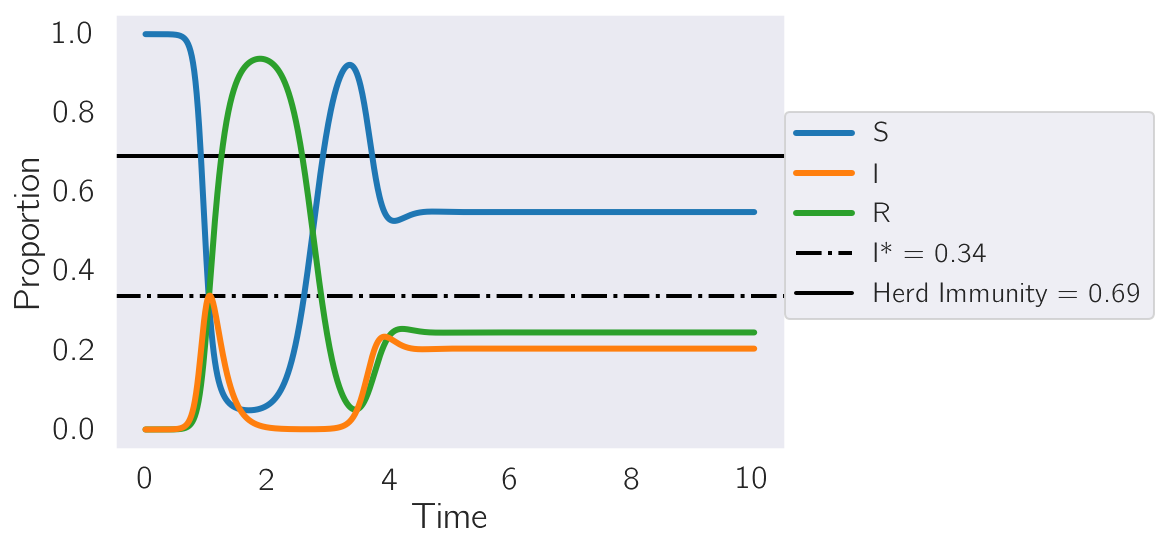

In [479]:
def SIR_birth_death(V, t, params):
    """ODE model for SIR with constant pop plus births and deaths"""
    S, I, R = V
    N = S + I + R
    mu, b, g = params
    dsdt = mu - b * S * I / N - mu * S
    didt = b * S * I / N - g * I - mu * I
    drdt = g * I - mu * R
    return [dsdt, didt, drdt]

t = np.linspace(0, 10, 1000)  # time to run simulation
sir = odeint(SIR_birth_death, V0, t, args=([5, 20, 6],))
plot_sir(sir)

In the following phase plot, I show that, for a balanced birth-death model and a variety of $r_0$ values, there are no oscillations. In this plot, lighter grays indicate larger $r_0$, and all trajectories start at $(1, 10^{-6})$. Notice how the different cycles all converge on a variety of locations on the phase plot, marked approximately by red points. In general, $I_\infty >0$ for these models. In the event where $r_0 > 1, I_0 > 0$, the disease becomes endemic and never dies out.  

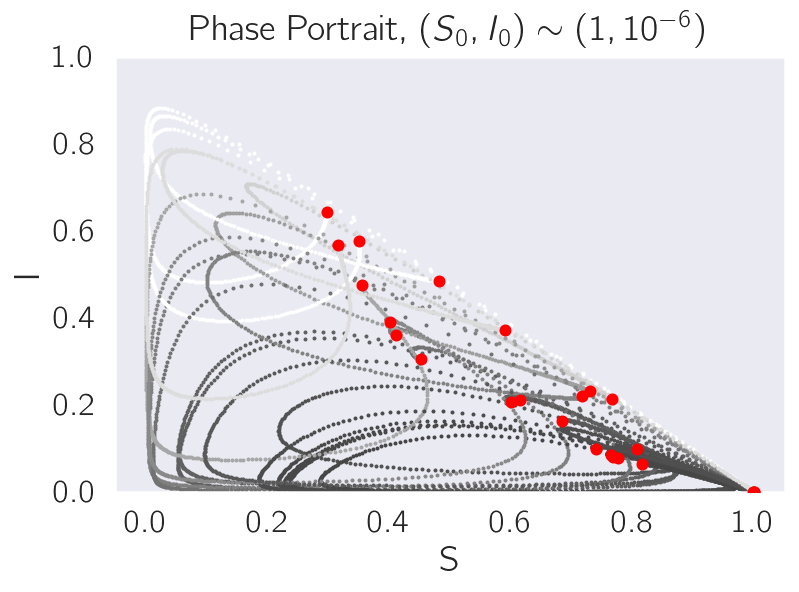

In [480]:
plot_simulations(SIR_birth_death, args=(5,))

## SIR model, births, deaths and newborn vaccines

Here is the modified model, with birth and death rates equal to $\mu$ and vaccination rate, $\theta \in [0, 1]$:

$$
\frac{d}{dt} S = \mu (1 - \theta) - \beta \frac{I}{N}S - \mu S\\
\frac{d}{dt} I = \beta \frac{I}{N}S - \gamma I - \mu S\\
\frac{d}{dt} R = \mu \theta + \gamma I - \mu R
$$

Again, infections peak when $\frac{d}{dt} I = 0$, which in this model happens when:

$$
\frac{S^*}{N} = \frac{\mu + \gamma}{\beta} = \frac{1}{r_0}
$$

For this model, it turns out that the disease will remain endemic in the population if and only if:

$$
\theta < 1 - \frac{1}{r_0}
$$

In other words, **the successful vaccination rate must be greater than the viral infectivity in the absence of social distancing and biological interventions**. For SARS-Cov2, there is reason to suspect that $r_0 \sim 8 - 10$. Thus, any successful vaccine needs to protect at a rate > 87.5%. Fortunately, the Moderna and Pfizer vaccines have a protection >90%, which means we should be able to wipe out SARS-Cov2 if we vaccinate aggressively enough.

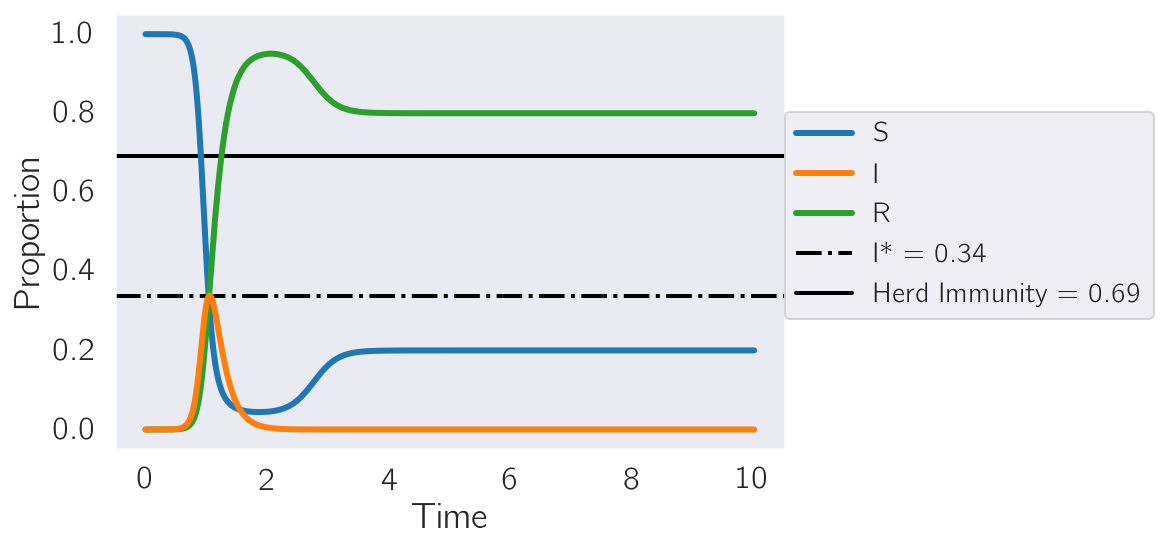

In [481]:
def SIR_birth_death_vax(V, t, params):
    """SIR model with balanced birth/deaths and newborn vaccination."""
    S, I, R = V
    N = S + I + R
    mu, theta, b, g = params
    dsdt = mu * (1 - theta) - b * S * I / N - mu * S
    didt = b * S * I / N - g * I - mu * I
    drdt = mu * theta + g * I - mu * R
    return [dsdt, didt, drdt]

t = np.linspace(0, 10, 1000)
sir = odeint(SIR_birth_death_vax, V0, t, args=([5,  8 * 10 ** -1, 20, 6],))
plot_sir(sir)

In the phase plot below, I explore dynamic trajectories where the birth rate is 5, the vaccine efficiency, $\theta$, is 0.3 and $1.6 < r_0 < \infty$. It turns out that when $\theta < 1 - \frac{1}{r_0}$ is true, then it is impossible to extinguish the disease. In these cases, we see cyclical behavior converging on a point in the phase space where $I_\infty > 0$. In the event that $\theta > 1 - \frac{1}{r_0}$, however, then the limiting behavior of the dynamics is to reach $S_\infty = 1 - \theta, I_\infty = 0$ (marked by the thin dotted red line).

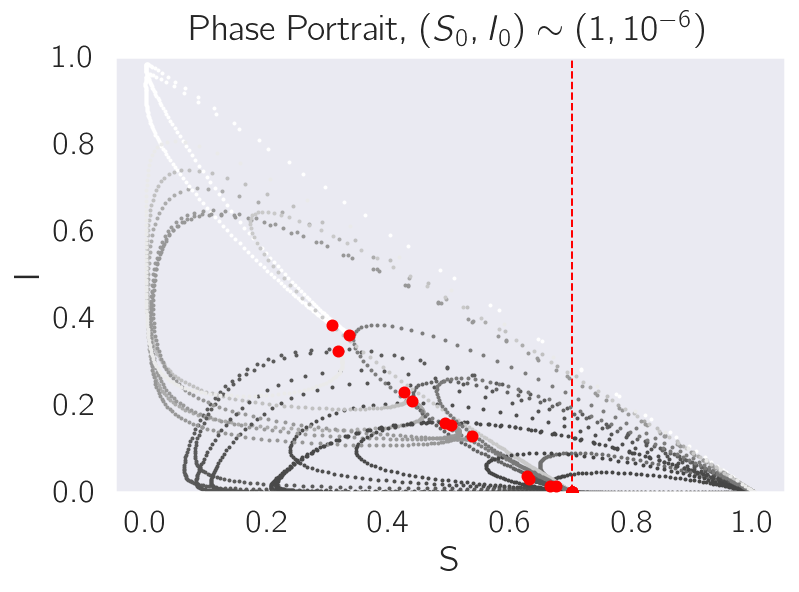

In [486]:
plt.axvline(0.7, ls='--', lw=1, color='red')
plot_simulations(SIR_birth_death_vax, args=(5, .3,), t=np.linspace(0, 100, 5000))

# Appendix

Size of the infection peak. Below, I simulate a range of $r_0$ values for the first SIR model and plot $r_0$ for that model versus the maximal infection proportion, $I^*$. For reasons that I don't entirely understand, and which came to me in a sort of haze, it turns out that a very reasonable approximation to the peak for a range of $r_0$ values is:

$$
I^* = \frac{r_0}{5 + r_0}e^{-\frac{3}{4}(r_0 - 1)}
$$

In [393]:
IS = []
betas = []
gammas = []

for i in range(1000):
    beta = np.random.uniform(3, 20)
    gamma = np.random.uniform(0, 10)

    # skip values of $r_0$ that are too small:
    if beta / gamma < 1.6:
        continue
    
    # create model:
    sir = odeint(SIR_basic, V0, t, args=([beta, gamma],))
    # find peak:
    istar = sir[:, 1].max() / N
    IS += [istar]
    betas += [beta]
    gammas += [gamma]

betas = np.array(betas)
gammas = np.array(gammas)
IS = np.array(IS)

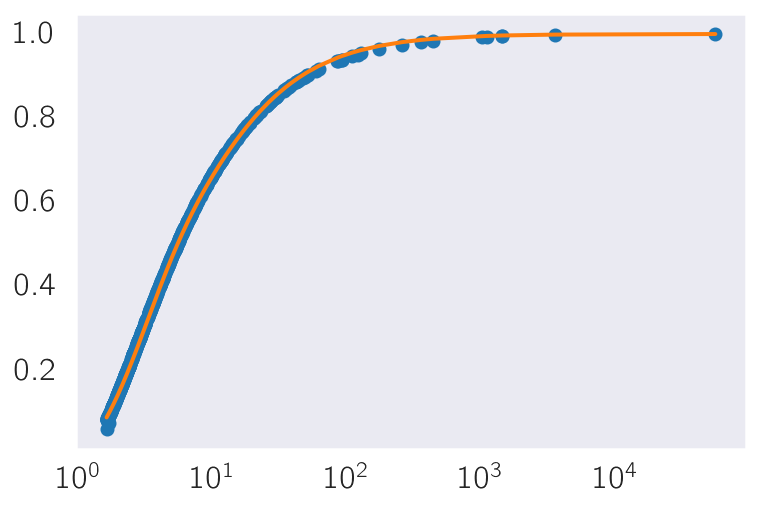

In [394]:
plt.plot(betas / gammas, IS, 'o')
x = np.sort(betas / gammas)
idx = np.argsort(betas / gammas)
plt.plot(x, x ** 1 / (5 + x ** 1) * (1 - np.exp(-0.75 * (x - 1))))
plt.xscale('log')

If we run scipy.optimize on a model to verify the equation above, we find excellent agreement with the equation I am proposing. In the future, I ought to figure out if this equation is an heuristic or if it is exact.

In [464]:
def model(x, m, a):
    """Estimate function for peak infection rate."""
    return x / (m + x) * (1 - np.exp(- a * (x - 1)))
params = cf(model, betas / gammas, IS, p0=[5, 1])
print("Best fit equation, two decimal digits:")
print("x / ({0:.2g} + x) * (1 - e ^ (- {1:.2g}(x - 1)))".format(*params[0]))

Best fit equation:
x / (5 + x) * (1 - e ^ (- 0.78(x - 1)))


A pretty close fit! Now go figure out how you can get vaccinated!